## Machine Learning exam, Andrea Milici

In [47]:
from data.DataExplorator import DataExplorator
from data.DataLoader import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from utils.conv import output_dim

import torch
import torch.nn as nn


In [48]:
# Carica il dataset, di default lo converte in (N,24,15,15) e ritorna un dataframe pandas
dataloader = DataLoader("/auto_atlas/atlas/atlas_gen_fs/amilici/other_samples/ml_exam_dataset/data_quench.json") # transform_to_2d= True di default
data= dataloader.get_data()

# Data exploration

Quench:  [{'step': 5, 'pixel': [13, 4], 'temp': 24.82027995288307}, {'step': 7, 'pixel': [1, 8], 'temp': 24.085982981441934}]


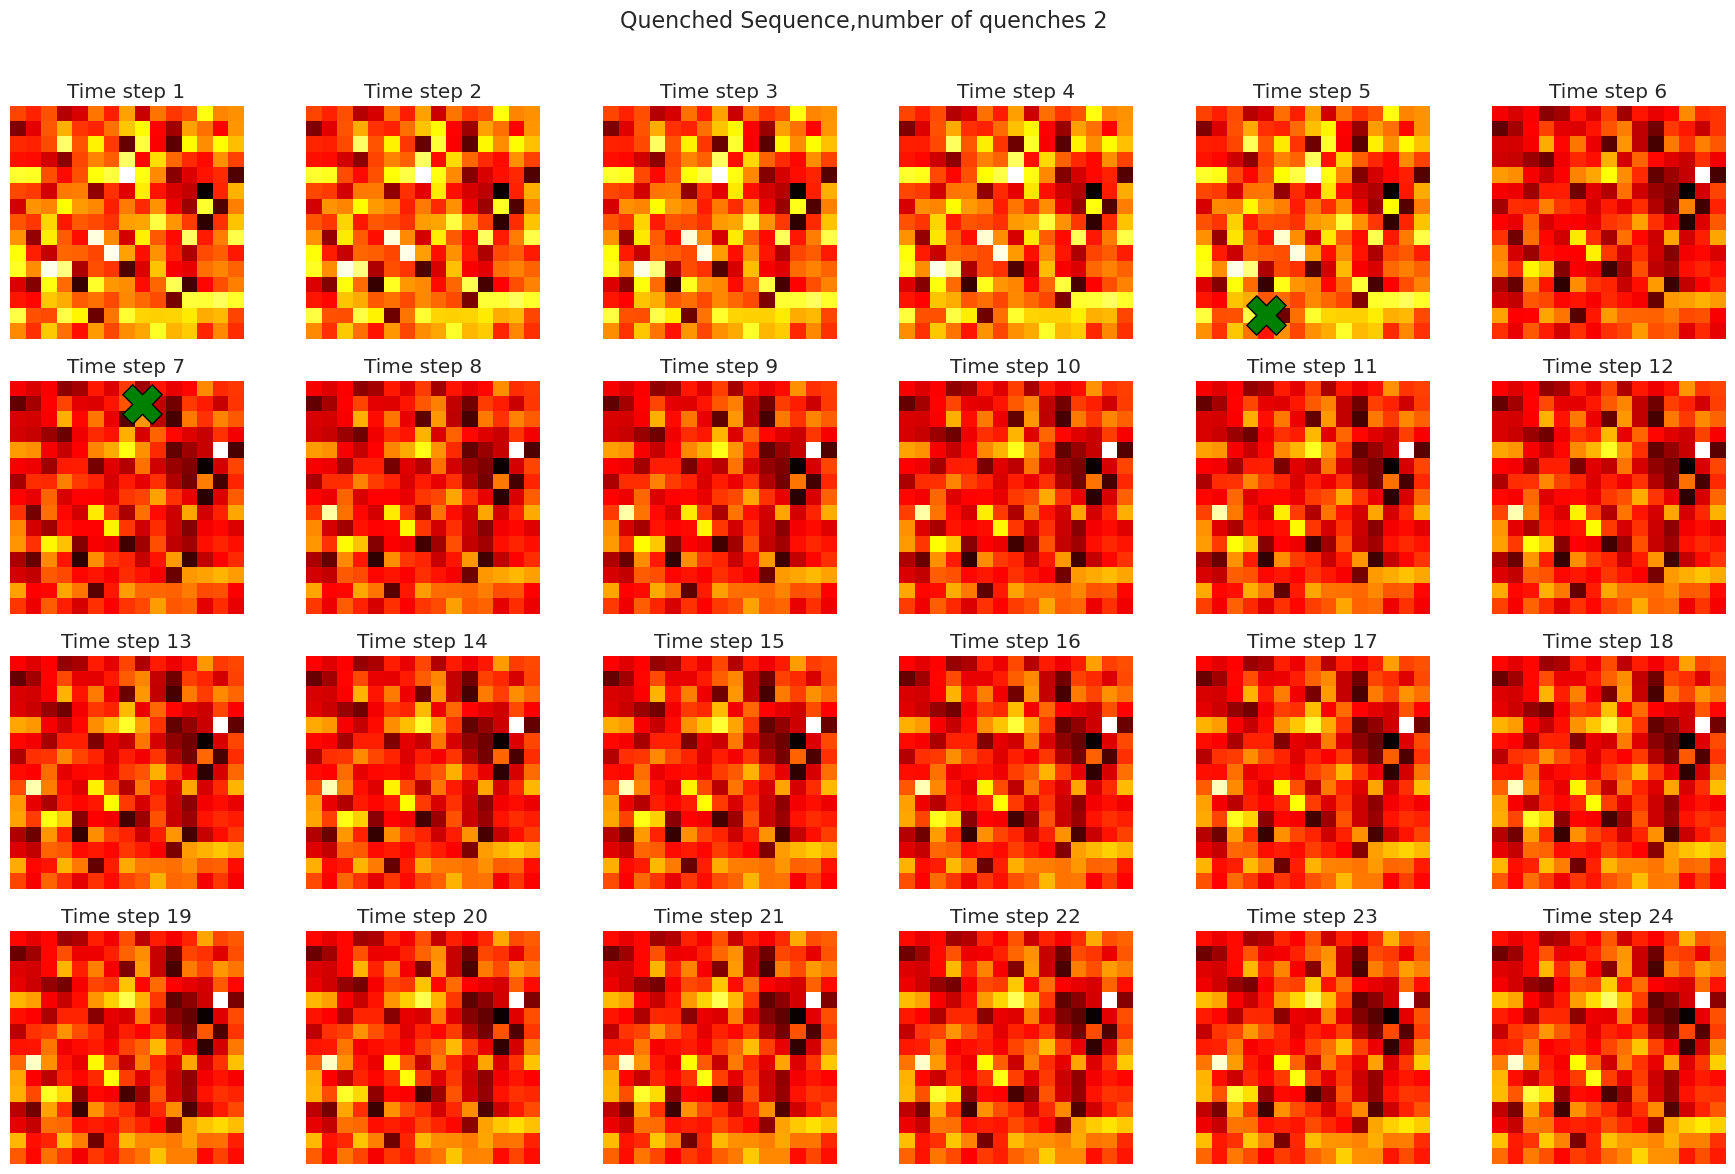

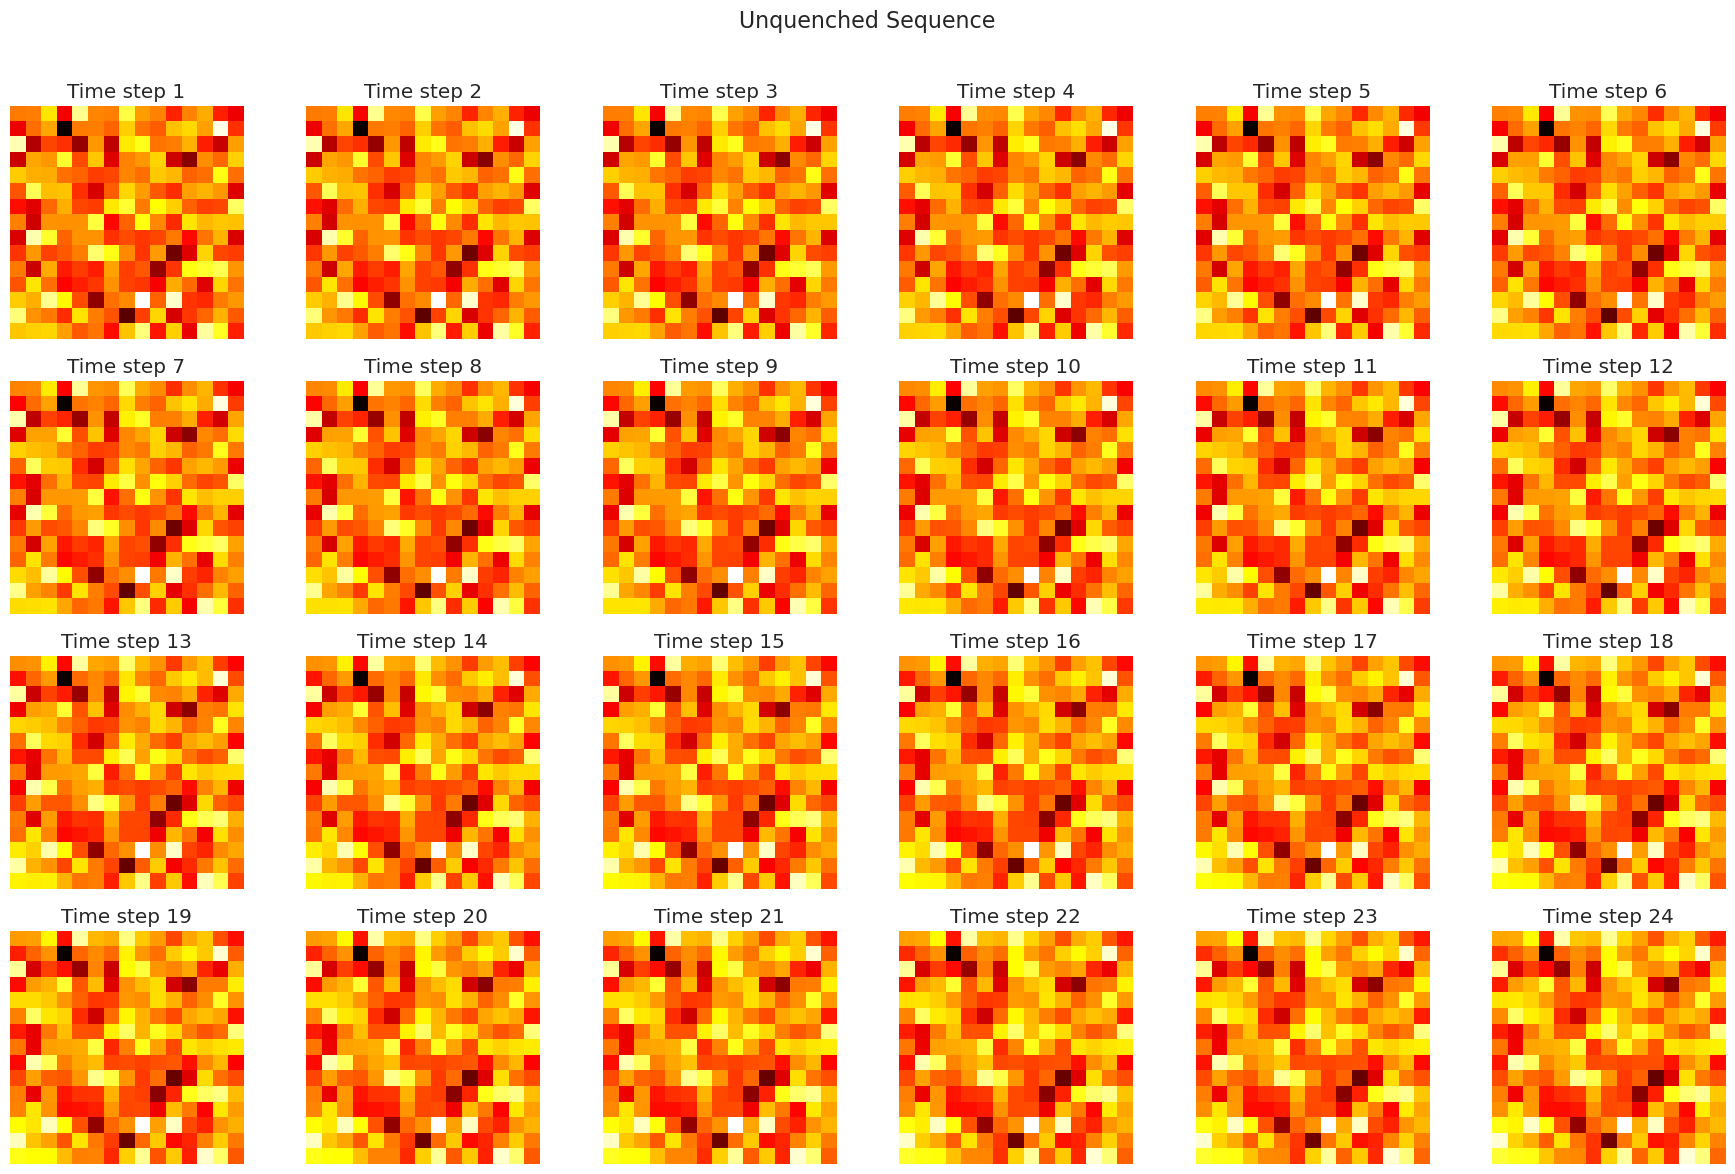

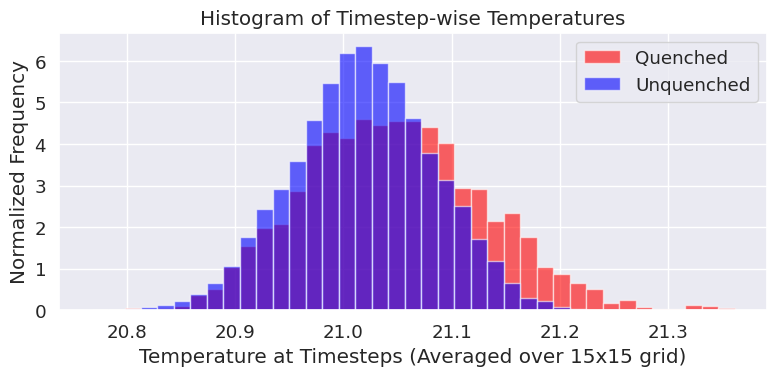

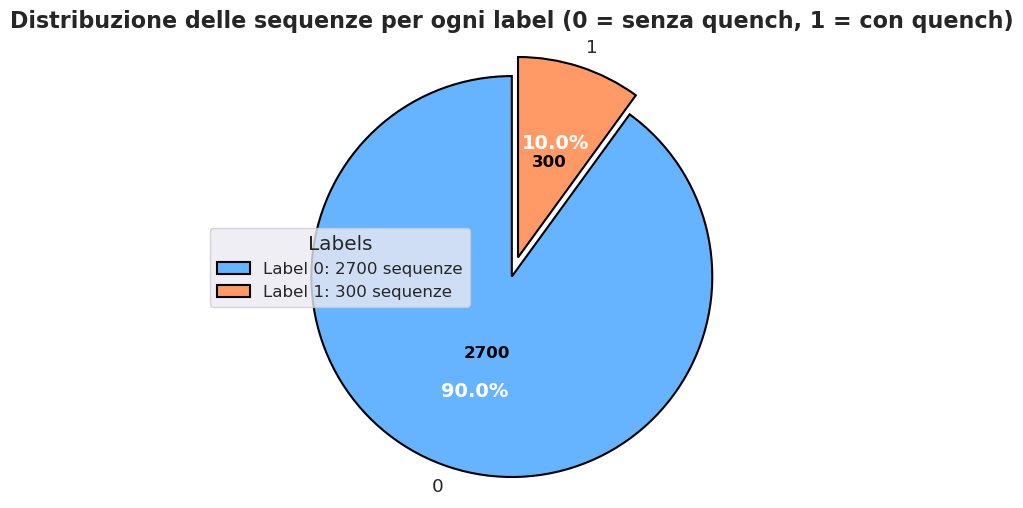

In [49]:
exploration = DataExplorator(data) 
# Vediamo una sequenza di heatmap con label == 1
exploration.visualize_sequence(quenched=True,debug=True)
# Vediamo una sequenza di heatmap con label == 0
exploration.visualize_sequence(quenched=False)
exploration.more_data_exploration()

In [50]:
#Preprocessing: Normalizzazione dei dati
# Trova min e max globali su tutto il dataset

all_values = np.concatenate([sequence.flatten() for sequence in data.sequence])
global_min = np.min(all_values)
global_max = np.max(all_values)
denom = global_max - global_min
data.sequence = (data.sequence- global_min)/denom

In [51]:



from data.torch_Dataset import torch_Dataset
full_dataset = torch_Dataset(data, grid_size=15)


# Creazione del DataLoader
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Train/test split
test_ratio = 0.5
test_size = int(len(full_dataset) * test_ratio)
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
class CNN_3D(nn.Module):
    def __init__(self):
        super(CNN_3D, self).__init__()
        # Definizione della rete CNN 3D
        
        self.cnn3d = nn.Sequential(
            nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1),  # -> (N,8,24,15,15)
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),                          # -> (N,8,12,7,7)
            
            nn.Conv3d(8, 16, kernel_size=3, padding=1),           # -> (N,16,12,7,7)
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2),                          # -> (N,16,6,3,3)


))
        self.flatten_size = 16 * 6* 3 * 3 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 1),  # output singolo
            )

    def forward(self, x):
        x = self.cnn3d(x)
        x = self.classifier(x)
        return x


In [53]:
model = CNN_3D()
# Definizione della funzione di perdita e dell'ottimizzatore
pos_weight= torch.tensor([len(data[data.label==0])/len(data[data.label==1])])  # Peso per la classe positiva, da regolare in base al dataset
print("Pos weight:", pos_weight)
loss_BCEWithLogits= nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Per classificazione binaria
#loss_BCE= nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Pos weight: tensor([9.])


In [54]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)
print(f"Parametri totali: {total_params}")
print(f"Parametri trainabili: {trainable_params}")

def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()


Parametri totali: 4561
Parametri trainabili: 4561


In [55]:
num_epochs = 150 # or however many epochs you want

train_losses = []
test_losses = []
loss_fn = loss_BCEWithLogits  

for epoch in range(num_epochs):

    if epoch ==0:
        model.apply(reset_weights)

    # ---- Training ----

    model.train()
    total_train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        
        loss = loss_fn(preds, batch_y)  
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * batch_x.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)

    # ---- Evaluation ----
    model.eval()
    total_test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            
            preds = model(batch_x)
            loss = loss_fn(preds, batch_y)
            total_test_loss += loss.item() * batch_x.size(0)

            probs = torch.sigmoid(preds)
            predicted = (probs >= 0.5).float()
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_accuracy = correct / total * 100
    

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

Epoch 01 | Train Loss: 1.2544 | Test Loss: 1.2432 | Test Acc: 9.93%
Epoch 02 | Train Loss: 1.2515 | Test Loss: 1.2428 | Test Acc: 90.07%
Epoch 03 | Train Loss: 1.2499 | Test Loss: 1.2394 | Test Acc: 9.93%
Epoch 04 | Train Loss: 1.2502 | Test Loss: 1.2379 | Test Acc: 81.53%
Epoch 05 | Train Loss: 1.2380 | Test Loss: 1.2633 | Test Acc: 9.93%
Epoch 06 | Train Loss: 1.2259 | Test Loss: 1.2111 | Test Acc: 9.93%
Epoch 07 | Train Loss: 1.1739 | Test Loss: 1.1580 | Test Acc: 10.27%
Epoch 08 | Train Loss: 1.0883 | Test Loss: 1.0576 | Test Acc: 95.20%
Epoch 09 | Train Loss: 0.9540 | Test Loss: 1.1417 | Test Acc: 92.27%
Epoch 10 | Train Loss: 0.8886 | Test Loss: 0.9452 | Test Acc: 94.00%
Epoch 11 | Train Loss: 0.7563 | Test Loss: 0.8388 | Test Acc: 70.27%
Epoch 12 | Train Loss: 0.6604 | Test Loss: 0.7132 | Test Acc: 96.47%
Epoch 13 | Train Loss: 0.5684 | Test Loss: 0.6409 | Test Acc: 96.53%
Epoch 14 | Train Loss: 0.5248 | Test Loss: 0.5996 | Test Acc: 94.07%
Epoch 15 | Train Loss: 0.5114 | Test L

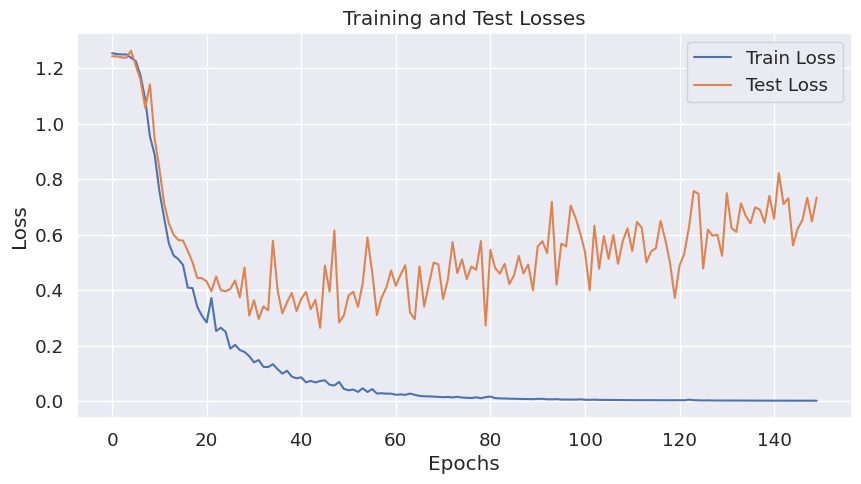

In [56]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


In [57]:
x_all = torch.stack([x for x, y in test_dataset])
y_all = torch.stack([y for x, y in test_dataset])

model.eval()
with torch.no_grad():
    logits = model(x_all)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()

# Valutazione
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

acc = accuracy_score(y_all, preds)
conf_mat = confusion_matrix(y_all, preds)
roc_auc = roc_auc_score(y_all, probs)

print(f"Accuracy:  {acc*100:.2f}%")
print("Confusion matrix:\n", conf_mat)
print(f"ROC AUC:   {roc_auc:.4f}")

Accuracy:  98.27%
Confusion matrix:
 [[1350    1]
 [  25  124]]
ROC AUC:   0.9884


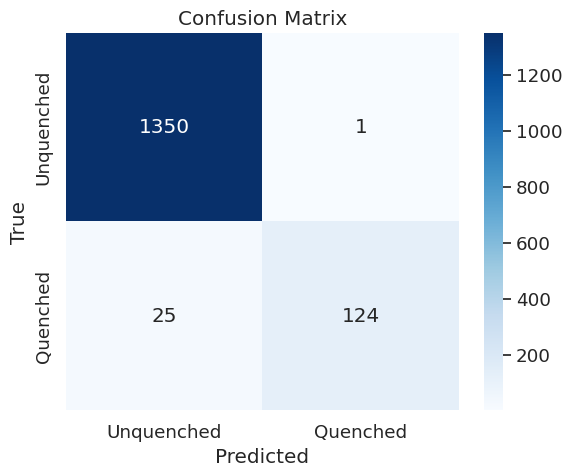

In [58]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Plot a confusion matrix with counts in each cell.

    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - labels: list of label names, optional
    - title: title of the plot
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_all, preds, labels=["Unquenched", "Quenched"])




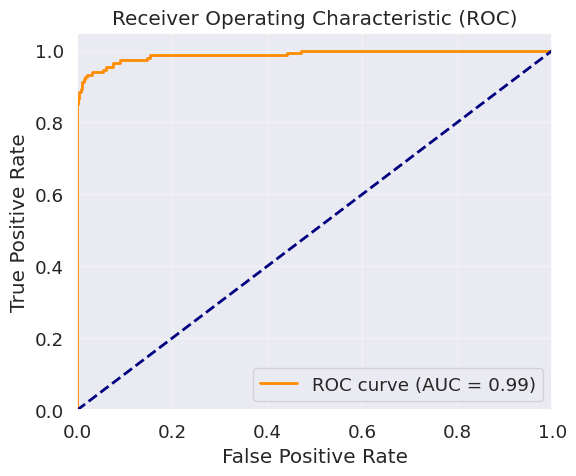

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(y_all, probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonale random
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
